In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import transforms
import glob
import tarfile
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
from transformers import get_scheduler
from transformers import BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.optim import AdamW
from opacus import PrivacyEngine

In [2]:
!gdown 1jxJNYCc3K_ad-_iT65MZob8nRWKCItV5

Downloading...
From: https://drive.google.com/uc?id=1jxJNYCc3K_ad-_iT65MZob8nRWKCItV5
To: /home/jovyan/work/Projects/EEG_Report_Classification/TUAB_txt_relabelled.tar
100%|███████████████████████████████████████| 12.3M/12.3M [01:05<00:00, 188kB/s]


In [3]:
tar = tarfile.open("./TUAB_txt_relabelled.tar")
tar.extractall()
tar.close()

In [4]:
main_dataset_dir = '/home/jovyan/work/Projects/EEG_Report_Classification/TUAB_txt_relabelled/v2.0.0/edf/'
train_dataset_dir = main_dataset_dir + 'train/'
test_dataset_dir = main_dataset_dir + 'eval/'
saved_models_dir = "/home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/"

In [5]:
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

def read_text_file(file_path):
    # List of encodings to try
    encodings = ['utf-8', 'iso-8859-1', 'windows-1252', 'ascii']
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as file:
                return file.read()
        except UnicodeDecodeError:
            # If an error occurs, move to the next encoding
            continue
    # If none of the encodings work, return None or handle the case as needed
    return None


class TextReportsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = glob.glob(os.path.join(root_dir, '**/*.txt'), recursive=True)
        self.data = []
        self.labels = []
        
        for file_path in self.file_paths:
            if 'abnormal' in file_path:
                self.labels.append(1)
            elif 'normal' in file_path:
                self.labels.append(0)
            else:
                continue
            text = read_text_file(file_path)
            if self.transform:
                text = self.transform(text)
            self.data.append(text)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids, attention_mask = self.data[idx]
        label = self.labels[idx]
        # Remove extra dimensions, if any (especially if using unsqueeze in your preprocessing)
        input_ids = input_ids.squeeze()
        attention_mask = attention_mask.squeeze()
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}


# Example transform function - this should be replaced with actual preprocessing
def preprocess_text(text):
    # Encode the texts using the ClinicalBERT tokenizer
    # 'return_tensors' argument tells the function to return PyTorch tensors
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=512,  # Set maximum length to 512 tokens
        truncation=True,  # Truncate longer sequences
        padding='max_length',  # Pad shorter sequences
        return_attention_mask=True,
        return_tensors='pt'  # Return PyTorch tensors
    )
    return encoded_text['input_ids'], encoded_text['attention_mask']

In [6]:
train_dataset = TextReportsDataset(root_dir=train_dataset_dir, transform=preprocess_text)
test_dataset = TextReportsDataset(root_dir=test_dataset_dir, transform=preprocess_text)

# Splitting train dataset into train and validation sets (80/20 split)
num_train = int(len(train_dataset) * 0.8)
num_val = len(train_dataset) - num_train
train_subset, val_subset = random_split(train_dataset, [num_train, num_val])


In [7]:
# Create DataLoaders for train, validation, and test
train_dataloader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=2)

# Choose device available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def clip_gradients(model, max_norm):
    """Clips the gradients computed during backpropagation to have a maximum norm of `max_norm`."""
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

def add_noise(model, noise_level):
    """Adds Gaussian noise to the gradients to ensure differential privacy."""
    for param in model.parameters():
        if param.grad is not None:
            noise = torch.randn_like(param.grad) * noise_level
            param.grad += noise

def train_and_validate(model, train_dataloader, val_dataloader, optimizer, device, epochs=3, saved_models_path=saved_models_dir, use_dp=True, max_grad_norm=1.0, noise_level=0.1):
    """Train and validate the model, with optional differential privacy.
    
    Args:
        model (torch.nn.Module): The model to train and validate.
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer): Optimizer for the model.
        device (torch.device): Device to run the model computation.
        epochs (int): Number of epochs to train the model.
        saved_models_path (str): Directory path where the model will be saved.
        use_dp (bool): Whether to use differential privacy measures.
        max_grad_norm (float): Maximum norm for gradient clipping (used if use_dp is True).
        noise_level (float): Standard deviation of Gaussian noise added to gradients (used if use_dp is True).
    """
    model = model.to(device)
    best_val_accuracy = 0

    total_steps = len(train_dataloader) * epochs
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Training"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()

            if use_dp:
                # Clip gradients to prevent large updates
                clip_gradients(model, max_grad_norm)
                # Add Gaussian noise to gradients
                add_noise(model, noise_level)

            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Average training loss: {avg_train_loss:.4f}")

        model.eval()
        total_val_loss = 0
        total_correct = 0
        total_examples = 0

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Validation"):
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                total_val_loss += loss.item()

                logits = outputs.logits
                predictions = torch.argmax(logits, dim=1)
                total_correct += (predictions == batch['labels']).sum().item()
                total_examples += batch['labels'].size(0)

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = total_correct / total_examples
        print(f"Average validation loss: {avg_val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            save_path = os.path.join(saved_models_path, f"{model.__class__.__name__}_best_model.pth")
            torch.save(model.state_dict(), save_path)
            print(f"Saved improved model at {save_path}")

In [10]:
train_and_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    device=device,
    epochs=30
)

Epoch 1/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.97it/s]


Average training loss: 0.6998


Epoch 1/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.85it/s]


Average validation loss: 0.6938
Validation accuracy: 0.5074
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 2/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.6921


Epoch 2/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.85it/s]


Average validation loss: 0.6877
Validation accuracy: 0.5276
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 3/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.6833


Epoch 3/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Average validation loss: 0.6664
Validation accuracy: 0.6985
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 4/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.6463


Epoch 4/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Average validation loss: 0.6080
Validation accuracy: 0.7132
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 5/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.5728


Epoch 5/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


Average validation loss: 0.5430
Validation accuracy: 0.7390
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 6/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.5160


Epoch 6/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Average validation loss: 0.5114
Validation accuracy: 0.7426
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 7/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.4816


Epoch 7/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.85it/s]


Average validation loss: 0.4952
Validation accuracy: 0.7463
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 8/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.4549


Epoch 8/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Average validation loss: 0.4594
Validation accuracy: 0.7886
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 9/30 - Training: 100%|██████████| 272/272 [02:19<00:00,  1.96it/s]


Average training loss: 0.4244


Epoch 9/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.82it/s]


Average validation loss: 0.4296
Validation accuracy: 0.8033
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 10/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.3944


Epoch 10/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Average validation loss: 0.4113
Validation accuracy: 0.8180
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 11/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.3609


Epoch 11/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Average validation loss: 0.3700
Validation accuracy: 0.8364
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 12/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.3307


Epoch 12/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.86it/s]


Average validation loss: 0.3384
Validation accuracy: 0.8548
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 13/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.3017


Epoch 13/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.86it/s]


Average validation loss: 0.3038
Validation accuracy: 0.8732
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 14/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.2728


Epoch 14/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.86it/s]


Average validation loss: 0.2680
Validation accuracy: 0.8842
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 15/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.2440


Epoch 15/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Average validation loss: 0.2365
Validation accuracy: 0.8989
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 16/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.2205


Epoch 16/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.82it/s]


Average validation loss: 0.2096
Validation accuracy: 0.9136
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 17/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.1965


Epoch 17/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.85it/s]


Average validation loss: 0.1810
Validation accuracy: 0.9283
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 18/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.1777


Epoch 18/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Average validation loss: 0.1574
Validation accuracy: 0.9412
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 19/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.1578


Epoch 19/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.86it/s]


Average validation loss: 0.1401
Validation accuracy: 0.9522
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 20/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.1380


Epoch 20/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Average validation loss: 0.1252
Validation accuracy: 0.9559
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 21/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.1283


Epoch 21/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.86it/s]


Average validation loss: 0.1146
Validation accuracy: 0.9596
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 22/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.1163


Epoch 22/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.86it/s]


Average validation loss: 0.1039
Validation accuracy: 0.9669
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 23/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.1101


Epoch 23/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


Average validation loss: 0.0966
Validation accuracy: 0.9724
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 24/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.1060


Epoch 24/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


Average validation loss: 0.0920
Validation accuracy: 0.9724


Epoch 25/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.0968


Epoch 25/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Average validation loss: 0.0887
Validation accuracy: 0.9706


Epoch 26/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.0879


Epoch 26/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Average validation loss: 0.0862
Validation accuracy: 0.9724


Epoch 27/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.0873


Epoch 27/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


Average validation loss: 0.0835
Validation accuracy: 0.9743
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 28/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.0789


Epoch 28/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.83it/s]


Average validation loss: 0.0818
Validation accuracy: 0.9761
Saved improved model at /home/jovyan/work/Projects/EEG_Report_Classification/SavedModels/ClinicalBERT/BertForSequenceClassification_best_model.pth


Epoch 29/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.0838


Epoch 29/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.84it/s]


Average validation loss: 0.0808
Validation accuracy: 0.9743


Epoch 30/30 - Training: 100%|██████████| 272/272 [02:18<00:00,  1.96it/s]


Average training loss: 0.0907


Epoch 30/30 - Validation: 100%|██████████| 68/68 [00:11<00:00,  5.86it/s]

Average validation loss: 0.0803
Validation accuracy: 0.9761


In [11]:
def evaluate_model_and_plot(model, dataloader, device):
    """Evaluate the model and plot metrics and confusion matrix."""
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    class_report = classification_report(true_labels, predictions, target_names=['Normal', 'Abnormal'], output_dict=True)
    conf_matrix = confusion_matrix(true_labels, predictions)

    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=['Normal', 'Abnormal']))

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {"accuracy": accuracy, "report": class_report, "confusion_matrix": conf_matrix}

In [13]:
# Step 1: Recreate the model architecture
model = BertForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=2,  # Ensure this matches the setup during training
    output_attentions=False,
    output_hidden_states=False,
)

# Step 2: Load the saved model weights
model_path = saved_models_dir+'BertForSequenceClassification_best_model.pth'
model.load_state_dict(torch.load(model_path))

# Step 3: Prepare the model for evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Accuracy: 0.9710144927536232
Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       150
    Abnormal       0.97      0.97      0.97       126

    accuracy                           0.97       276
   macro avg       0.97      0.97      0.97       276
weighted avg       0.97      0.97      0.97       276



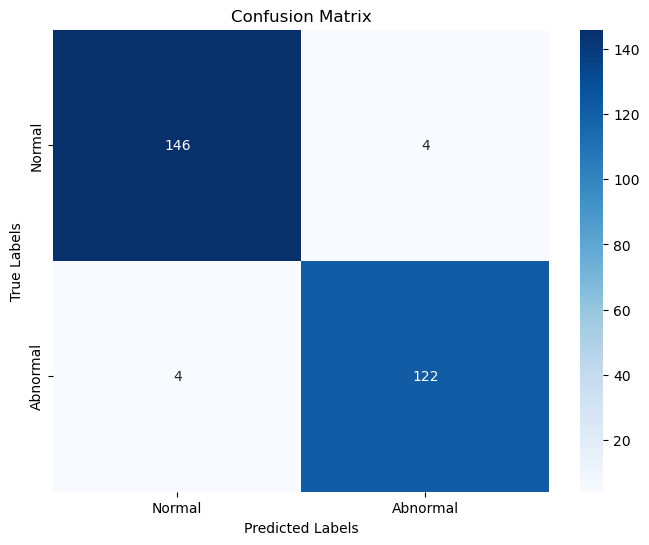

In [14]:
# model evaluation finally done here
results = evaluate_model_and_plot(model, test_dataloader, device)